# 偏微分方程
---

偏微分方程（PDE）是多元微分方程，方程中的导数是偏导数。处理ODE和PDE所需的计算方法大不相同，后者对计算的要求更高。

[数值求解PDE](https://zh.wikipedia.org/zh-cn/偏微分方程數值方法)的大多数技术都基于将PDE问题中的每个因变量离散化的思想，从而将微分问题变换为代数形式。将PDE转化为代数问题的两种常用技术是[有限差分法](https://zh.m.wikipedia.org/zh-hans/有限差分法)（FDM）和[有限元法](https://zh.m.wikipedia.org/zh-hans/有限元素法)（FEM）。其中有限差分法是将问题中的导数近似为有限差分，而有限元法则是将未知函数写成简单基函数的线性组合，其中基函数可以较容易进行微分和积分。未知函数可以表示为基函数的一组系数。

求解PDE问题所需的计算资源一般都非常大，一部分原因是对空间进行离散化所需要点的数量与维数是指数关系。例如一个一维问题如果需要用100个点来表示，那么具有类似分辨率的二维问题将需要10000个点。由于离散空间中的每个点都对应一个未知变量，因此PDE问题需要非常大的方程组。与OED问题不同，不存在标准形式对任意PDE问题进行定义。

对于FDM和FEM，得到的代数方程组一般都非常大。在矩阵表示下，此类方程组一般都非常稀疏。基于存储和计算效率考虑，FDM和FEM都非常依赖于稀疏矩阵来表示代数线性方程组。

## 导入模块
---

为了使用稀疏矩阵，我们将导入SciPy的sparse模块，以及sparse模块的linalg线性代数子模块。

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpl_toolkits.mplot3d
from IPython.display import display

import numpy as np
import sympy
import scipy.sparse as sp
import scipy.sparse.linalg
import scipy.linalg as la

In [2]:
%reload_ext version_information
%version_information numpy, matplotlib, scipy, sympy

Software versions
Python 3.9.7 64bit [GCC 9.4.0]
IPython 8.0.0
OS Linux 5.10.84 10.3.al8.x86_64 x86_64 with glibc2.32
numpy 1.21.2
matplotlib 3.5.1
scipy 1.5.3
sympy 1.9
Tue May 24 02:10:32 2022 CST

## 偏微分方程
---

PDE中的未知函数是多元函数。在N维问题中，函数$u$依赖于n个独立变量。一般的PDE可以写为：

$$F(x_1, x_2, \cdots, x_n, {\partial u \over \partial x_i}, {\partial ^{2}u \over \partial x_i\,\partial x_j} )=0, x \in \Omega$$

其中${\partial u \over \partial x_i}$表示自变量的所有一阶导数，${\partial ^{2}u \over \partial x_i\,\partial x_j}$表示所有二阶导数。这里的$F$是已知函数，用于描述PDE的形式，$\Omega$是PDE问题的定义域。

为了简化符号，通常使用$u_x = {\partial u \over \partial x_i}$表示自变量x的一阶偏导数，$u_{xy} = {\partial ^{2}u \over \partial x\,\partial y}$表示二阶导数。

大部分PDE问题最多包含二阶导数，并且通常是在二维或者三维空间中求解问题。例如热量方程在二维笛卡尔坐标系中的形式是$u_{t}= a(u_{xx} + u_{yy})$。这里函数$u(x, y, t)$用于描述时间$t$时，点$(x, y)$处的温度，$a$是热传导系数。

为了完全确定PDE的解，需要定义PDE的边界条件。边界条件是沿着问题域$\Omega$的函数值（[Dirichlet边界条件](https://zh.m.wikipedia.org/zh-hans/狄利克雷边界条件)）或者外法线导数（[Neumann边界条件](https://zh.m.wikipedia.org/zh-hans/诺伊曼边界条件)）的组合。如果问题是时间依赖的，那么还需要初始值。

## 有限差分法
---

有限差分法的基本思想是：利用离散空间中的有限差分公式来近似PDE中出现的导数。

例如，在将连续变量$x$离散化成$\left\{ x_n \right\}$时，常导数$\frac{du}{dx}$的有限差分公式可以表示为：

前向差分公式 $\frac{du}{dx} \approx \frac{u(x_{n+1}) - u(x_{n})}{x_{n+1} - x_{n}}$

后向差分公式 $\frac{du}{dx} \approx \frac{u(x_{n}) - u(x_{n-1})}{x_{n} - x_{n-1}}$

中心差分公式 $\frac{du}{dx} \approx \frac{u(x_{n+1}) - u(x_{n-1})}{x_{n+1} - x_{n-1}}$

同样，也可以为高阶导数（例如二阶）构造有限差分公式：
$$\frac{d^2u}{dx^2} \approx \frac{u(x_{n+1}) - 2 u(x_{n}) + u(x_{n-1})}{(x_{n+1} - x_{n-1})^2}$$

使用有限差分公式替代ODE或者PDE中的导数，就可以将微分方程转换为代数方程。

### 一维热传导

为了具体说明有限差分法，我们首先考虑一维稳态热方程中的ODE问题$u_{xx}= -5$，其中$x \in [0, 1]$，边界条件是$u(x=0)=1$和$u(x=1)=2$。与常微分方程章节中讨论的ODE初始值问题不同，这是边界值问题。

我们将区间$[0, 1]$均匀离散成N+2个空间点（包含边界点），这样问题就转换为了找到这些点的函数值$u(x_n)= u_n$。将ODE问题写为有限差分的形式，得到方程：

$$(u_{n-1} - 2u_{n} + u_{n+1}) / {\Delta x}^2 = -5 $$

其中间隔$\Delta x = 1/(N+1)$。

由于函数在两个边界点的值是已知的，因此存在N个位置变量，对应内部点的函数值。我们可以将内部点的方程组表示为矩阵形式 $Au=b$：

$$
\frac{1}{{\Delta x}^2}
\begin{bmatrix}\begin{array}{ccccccc}-2 & 1 & 0  & \ldots & 0  \\ 1 & -2 & 1 & \ldots & 0  \\ 0 & 1 & -2 & \ldots & 0  \\ \ldots & \ldots & \ldots & \ldots & \ldots \\ 0 & 0 & 0 & \ldots & -2 \end{array}\end{bmatrix}
\begin{bmatrix}\begin{array}{c} u_1 \\ u_2 \\ u_3 \\ \ldots \\ u_n \end{array}\end{bmatrix}
=\begin{bmatrix}\begin{array}{c} -5-\frac{u_0}{{\Delta x}^2} \\ -5 \\ -5 \\ \ldots \\ -5-\frac{u_{N+1}}{{\Delta x}^2} \end{array}\end{bmatrix}
$$

这里矩阵$A$描述了方程$u_n$和相邻点的耦合。边界值包含在向量$b$中。

现在，我们可以直接求解线性方程组$Au=b$中的未知向量$u$，从而获得离散点$\left\{ x_n \right\}$处函数的近似值。

In [3]:
N = 5
u0, u1 = 1., 2.
dx = 1.0 / (N + 1)

使用NumPy的eye函数，构造一个二维对角矩阵，同时使用参数k给定的偏移量生成上下对角线。

In [4]:
A = (np.eye(N, k=-1) - 2 * np.eye(N) + np.eye(N, k=1)) / dx**2
A

array([[-72.,  36.,   0.,   0.,   0.],
       [ 36., -72.,  36.,   0.,   0.],
       [  0.,  36., -72.,  36.,   0.],
       [  0.,   0.,  36., -72.,  36.],
       [  0.,   0.,   0.,  36., -72.]])

为向量$b$准备一个数组，该数组对应微分方程中的源项（热源）-5以及边界条件。

In [5]:
d = -5 * np.ones(N)
d[0] -= u0 / dx**2
d[N-1] -= u1 / dx**2
d

array([-41.,  -5.,  -5.,  -5., -77.])

使用SciPy的线性方程求解器求解方程组：

In [6]:
u = np.linalg.solve(A, d)
u

array([1.51388889, 1.88888889, 2.125     , 2.22222222, 2.18055556])

容易可知，该ODE问题的解析解为$u(x) = -2.5 x^2 + 3.5x + 1$。我们现在对解进行可视化。

Text(0, 0.5, '$u(x)$')

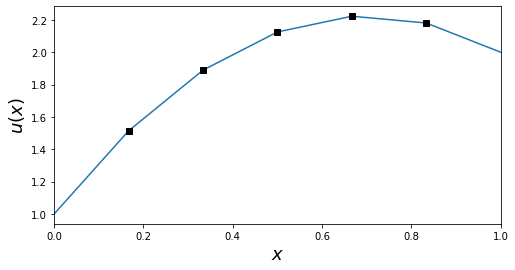

In [7]:
f = lambda x: -2.5*x**2 + 3.5*x + 1

x = np.linspace(0, 1, N+2)
U = np.hstack([[u0], u, [u1]])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, f(x))
ax.plot(x[1:-1], u, 'ks')
ax.set_xlim(0, 1)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$u(x)$", fontsize=18)

### 二维热传导

沿着每个离散化的坐标使用有限差分公式，可以很容易将有限差分法扩展到更高维度。对于二维问题，可以用二维数组$u$来表示未知的函数值。使用有限差分公式时，对于$u$中的每个元素可以得到一个耦合方程组。为了将这些方程写为标准的矩阵-向量点乘的形式，可以将二维数组$u$重排成向量，并构建有限差分方程对应的矩阵$A$。

考虑二维热传导问题，PDE为拉普拉斯公式 $u_{xx} + u_{yy} = 0$，源项为0，边界条件为：
$$u(x=0) = 3$$
$$u(x=1) = -1$$ 
$$u(y = 0) = -5$$
$$u(y = 1) = 5$$

有限差分形式为：
$$u_{xx}[m, n] = (u[m-1, n] - 2u[m,n] + u[m+1,n])/{\Delta x}^2$$
$$u_{yy}[m, n] = (u[m, n-1] - 2u[m,n] + u[m,n+1])/{\Delta y}^2$$

如果将x和y的区间分成N个内部点，那么$\Delta x = \Delta y = \frac{1}{N+1}$。

为了将方程写成标准形式$Au=b$，可以重新排布矩阵$u$，将其的行或者列叠加成大小为$N^2 \times 1$的向量。矩阵$A$的大小是$N^2 \times N^2$。由于有限差分公式中只有相邻点发生耦合，因此矩阵$A$很稀疏。

In [8]:
N = 100
u0_t, u0_b = 5, -5
u0_l, u0_r = 3, -1
dx = 1. / (N+1)

二维问题中相邻的行和列都会发生耦合，因此构造矩阵$A$会稍微复杂一些。一种相对直接的方式是首先定义矩阵$A_ld$，对应一个坐标轴上的一维公式。为了在每一行使用该公式，可以将大小为$N \times N$的对角矩阵与$A_ld$进行张量积计算。为了涵盖每一列上耦合方程的项，需要将与主对角线相隔$N$个位置的对角线相加。

我们将使用`scipy.sparse`模块中的`eye`和`kron`函数构造矩阵A。

In [9]:
A_1d = (sp.eye(N, k=-1) + sp.eye(N, k=1) - 4 * sp.eye(N))/dx**2
A = sp.kron(sp.eye(N), A_1d) + (sp.eye(N**2, k=-N) + sp.eye(N**2, k=N))/dx**2
A

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 49600 stored elements in Compressed Sparse Row format>

矩阵$A$的非零值有49600个，占总元素数目的0.496%，可见其非常稀疏。

从边界条件构建向量$b$，可以先生成一个$N \times N$的零值数组，并将边界条件赋值给数组的边元素。随后，可以用reshape方法，将其重排成$N^2 \times 1$的向量。

In [10]:
d = np.zeros((N, N))

d[0, :] += -u0_b 
d[-1, :] += -u0_t
d[:, 0] += -u0_l
d[:, -1] += -u0_r

d = d.reshape(N**2) / dx**2

生成数组$A$和向量$b$后，我们可以求解方程组，并使用reshape方法将$u$转成$N \times N$的矩阵。

In [11]:
u = sp.linalg.spsolve(A, d).reshape(N, N)

为了可视化绘图，我们创建一个矩阵$U$，将矩阵$u$和边界条件组合到一起。

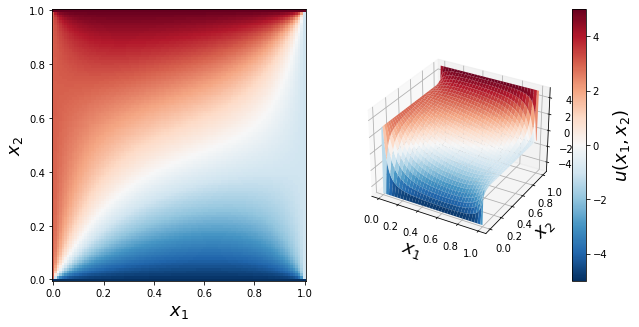

In [12]:
U = np.vstack([np.ones((1, N+2)) * u0_b,
               np.hstack([np.ones((N, 1)) * u0_l, u, np.ones((N, 1)) * u0_r]),
               np.ones((1, N+2)) * u0_t])

x = np.linspace(0, 1, N+2)
X, Y = np.meshgrid(x, x)

fig = plt.figure(figsize=(10, 5))
cmap = mpl.cm.get_cmap('RdBu_r')

ax1 = fig.add_subplot(1, 2, 1)
c = ax1.pcolor(X, Y, U, vmin=-5, vmax=5, cmap=cmap)
ax1.set_xlabel(r"$x_1$", fontsize=18)
ax1.set_ylabel(r"$x_2$", fontsize=18)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
p = ax2.plot_surface(X, Y, U, vmin=-5, vmax=5, rstride=3, cstride=3, cmap=cmap)
ax2.set_xlabel(r"$x_1$", fontsize=18)
ax2.set_ylabel(r"$x_2$", fontsize=18)

cb = plt.colorbar(p, ax=ax2)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)

#### 有源问题

考虑PDE问题 $u_{xx} + u_{yy} + 1 = 0$，边界值为0。

In [13]:
d = - np.ones((N, N))
d = d.reshape(N**2)
u = sp.linalg.spsolve(A, d).reshape(N, N)
np.max(u)

0.07365341100425057

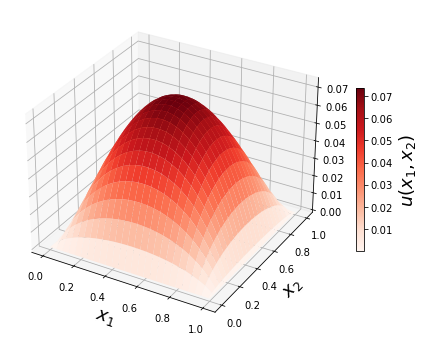

In [14]:
U = np.vstack([np.zeros((1, N+2)),
               np.hstack([np.zeros((N, 1)), u, np.zeros((N, 1))]),
               np.zeros((1, N+2))])

x = np.linspace(0, 1, N+2)
X, Y = np.meshgrid(x, x)

fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={'projection': '3d'})

p = ax.plot_surface(X, Y, U, rstride=4, cstride=4, linewidth=0, cmap=mpl.cm.get_cmap("Reds"))
cb = fig.colorbar(p, shrink=0.5)

ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)

### 稀疏矩阵性能

正如上面展示，使用FDM方法得到的矩阵$A$非常稀疏。我们下面对比稀疏矩阵和稠密矩阵求解方程$Au=b$所需的时间。

In [15]:
A_dense = A.todense()

In [16]:
%time sp.linalg.spsolve(A, d)

CPU times: user 67.5 ms, sys: 11 ms, total: 78.6 ms
Wall time: 63.8 ms


array([0.00027018, 0.00049134, 0.00068286, ..., 0.00068286, 0.00049134,
       0.00027018])

In [17]:
%time np.linalg.solve(A_dense, d)

CPU times: user 27.9 s, sys: 2.19 s, total: 30.1 s
Wall time: 15.8 s


array([0.00027018, 0.00049134, 0.00068286, ..., 0.00068286, 0.00049134,
       0.00027018])

In [18]:
%time la.solve(A_dense, d)

CPU times: user 40 s, sys: 2.78 s, total: 42.8 s
Wall time: 27.8 s


array([0.00027018, 0.00049134, 0.00068286, ..., 0.00068286, 0.00049134,
       0.00027018])

从上面示例可知，有限差分法是一种强大且简单的求解ODE边界值问题以及简单形状PDE问题的方法。但是，这种方法并不适用更复杂的问题（计算量过大），以及不均匀坐标网格的问题。对于此类问题，有限元法FEM更加灵活和方便。

## 有限元法
---

[有限元法](https://zh.m.wikipedia.org/zh-hans/有限元素法)FEM的基本思想是用有限的离散区域或单元的集合来代表PDE的定义域，并将未知函数近似为基函数$\left\{\phi_i(x)\right\}$的线性组合，而这些基函可以在每个单元（或一组相邻单元）上获得局部支撑。

在数学上，这种近似解$u_h$表示从无限维函数空间$V$中的精确解$u$到有限维子空间$V_h$的映射。如果$V_h$是$V$的合适子空间，可以预期$u_h$能够很好近似$u$。

### 变分法与PDE的弱变形

简单来说，有限差分法是基于泰勒展开的近似，有限元法是基于变分法的近似。

为了在简化的基函数支撑的函数空间$V_h$中求解近似问题，可以将PDE从原始公式（strong formulation）重写为对应的变体形式（weak formulation）。为了得到弱形式，我们将PDE乘以任意函数$v$，并在整个问题域上积分。函数$v$称为测试函数，通常可以在不用于$V$和$V_h$的函数空间$\hat{V}$中定义该函数。

在弱形式下，近似函数$g(x)$和原函数$f(x)$不能保证点对点一致，但是两个函数对测试函数$w(x)$的卷积是相等的：

$$\int_{\Omega}w(x)f(x)d\Omega=\int_{\Omega}w(x)g(x)d\Omega,\forall w(x)$$

测试函数$w(x)$可以任意选择。根据变分原理，测试函数的边界值为0。如果上式对任意测试函数都满足，弱形式和强形式等价。

测试函数的一个自然选择是基函数。对有限测试函数，要求其残差函数$R(x)=F(f(x)) - F(g(x))$的加权求和等于0（[伽辽金法](https://zh.m.wikipedia.org/wiki/伽辽金法)）：

$$\int_{\Omega}\phi_i(x)R(x)d\Omega=0, \forall \phi_i(x)$$


### FEM求解步骤

Python的PDE求解器只能由专门用于PDE问题的外部库和框架提供。我们将在后续章节中使用[FEniCSx](https://fenicsproject.org)框架进行演示。

通常而言，使用FEM求解PDE问题通常涉及以下步骤：
1. 为问题域生成网格
2. 将PDE写成弱形式
3. 在FEM框架中对问题进行编码
4. 求解得到的代数方程
5. 后续处理和可视化

### 一维冷却

下面我们将以牛顿冷却定律为例讲解FEM。

微分方程$\frac{dx(t)}{dt} + x(t) = 0$。初始条件$x(0)=1$，问题域$t \in [0, 1]$。

#### 基函数展开

这个方程的解析解是$e^{-t}$，它的泰勒展开为：

$$x(t) = e^{-t} = 1 - t + {1 \over 2!}t^2  - {1 \over 3!}t^3  + {1 \over 4!}t^4 + \cdots$$

如果忽略高阶项，将展开阶段到二阶，得到的近似解$g(t)$为：

$$x(t) \approx g(t) = 1 - t + {1 \over 2!}t^2$$

$g(t)$在$(1, t, t^2)$三个函数支撑起的函数空间$V_h$中，展开系数为$(1, -1, 0.5)$。将其带入原微分方程产生残差$R(t)$:

$${dg \over dt } + g = R, R= \frac{1}{2}t^2 \neq 0$$

函数$g(t)$在$(1, t, t^2)$基函数空间中的系数可以进一步改进，我们将其写为待定系数：

$$x(t) \approx g(t) = 1 + c_1t + c_2t^2$$

此时的残差函数为：

$$R(t) = 1 + (1 +t)c_1 + (2 t + t^2) c_2$$

理想的最优情况是$R(t)=0$，但是这个做不到。可以使用不同的方法减弱约束，求解待定系数。

#### 伽辽金法 Galerkin Method

根据待定系数的个数n，选取n个不同的测试函数$w_i(t)$，要求每个$w_i$都满足：

$$\int_0^1 w_i(t)R(t) dt = 0$$

n个方程恰好可以求解n个待定系数。

测试函数的一种自然选择是函数$x(t)$展开时使用的基函数$(t, t^2)$，可得：

$$\int_0^1 tR(t) dt = 0$$
$$\int_0^1 t^2R(t) dt = 0$$

求解上述线性方程组，可以得到优化后的展开系数。

In [19]:
t, c1, c2 = sympy.symbols("t, c1, c2")
x = sympy.exp(-t)
x_2nd_approx = x.series(t, n=3).removeO()
x_2nd_approx

t**2/2 - t + 1

In [20]:
g = 1 + c1*t + c2*t**2
R = g.diff(t) + g

In [21]:
Eq1 = sympy.integrate(t*R, (t, 0, 1))
Eq2 = sympy.integrate(t**2*R, (t, 0, 1))
sol = sympy.solve((Eq1, Eq2), (c1, c2))
g = g.subs(sol)
g

2*t**2/7 - 32*t/35 + 1

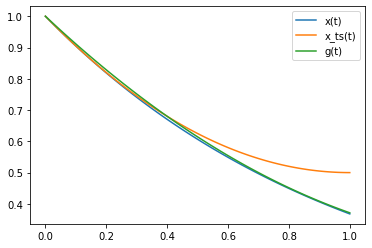

In [22]:
tt = np.linspace(0, 1, 100)

plt.plot(tt, sympy.lambdify(t, x)(tt), label='x(t)')
plt.plot(tt, sympy.lambdify(t, x_2nd_approx)(tt), label='x_ts(t)')
plt.plot(tt, sympy.lambdify(t, g)(tt), label='g(t)')
plt.legend()

可以发现，相对于低阶泰勒展开，使用伽辽金法优化后的近似函数残差明显降低。

#### 分片基函数展开

我们将未知函数$x(t)$离散为若干个节点。

例如，在$t \in [0, 1]$区间上等距设置3个节点（包含区间首尾），可以得到2个单元。除去初始条件$x_0 = 1$，共有2个未知节点$x_1$和$x_2$。

在2个区间上，近似函数分别为：
$$ g_0(t) = c_{00} + c_{01}t + c_{02}t^2$$
$$ g_1(t) = c_{10} + c_{11}(t-0.5) + c_{12}(t-0.5)^2$$

In [23]:
grid_size = 0.5
t = sympy.symbols("t")
c00, c01, c02 = sympy.symbols("c00, c01, c02")
c10, c11, c12 = sympy.symbols("c10, c11, c12")
g0 = c00 + c01*t + c02*t**2
g1 = c10 + c11*(t-grid_size) + c12*(t-grid_size)**2
display(g0)
display(g1)

c00 + c01*t + c02*t**2

c10 + c11*(t - 0.5) + c12*(t - 0.5)**2

其中$c_{00}=1$为初始条件，剩余5个为待定系数。

将近似函数代入微分方程$\frac{dg(t)}{dt} + g(t)$，得到残差函数：
$$R_0(t) = c_{00} + (1+t)c_{01} + (2t + t^2) c_{02}$$
$$R_1(t) = c_{10} + (1+(t-0.5)c_{11} + (2(t-0.5) + (t-0.5)^2) c_{12}$$

In [24]:
g0 = g0.subs(c00, 1)
R0 = g0.diff(t) + g0
R1 = g1.diff(t) + g1
display(R0)
display(R1)

c01*t + c01 + c02*t**2 + 2*c02*t + 1

c10 + c11*(t - 0.5) + c11 + c12*(t - 0.5)**2 + c12*(2*t - 1.0)

对应的弱形式分别为：
$$\int_0^{0.5} tR_0(t) dt = 0$$
$$\int_0^{0.5} t^2R_0(t) dt = 0$$
$$\int_{0.5}^{1} tR_1(t) dt = 0$$
$$\int_{0.5}^{1} t^2R_1(t) dt = 0$$

相邻区间函数在节点处值相等，因此$g_0(0.5)=g_{1}(0.5)$。共计5个约束条件，可以求解5个系数。

In [25]:
Eq0 = g0.subs(t, grid_size) - g1.subs(t, grid_size)
Eq1 = sympy.integrate(t*R0, (t, 0, grid_size))
Eq2 = sympy.integrate(t**2*R0, (t, 0, grid_size))
Eq3 = sympy.integrate(t*R1, (t, grid_size, 1))
Eq4 = sympy.integrate(t**2*R1, (t, grid_size, 1))

In [26]:
sol = sympy.solve((Eq0, Eq1, Eq2, Eq3, Eq4), (c01, c02, c10, c11, c12))
g0 = g0.subs(sol)
g1 = g1.subs(sol)
display(g0)
display(g1)

0.373831775700935*t**2 - 0.97196261682243*t + 1

-0.596117685710092*t + 0.236266155921683*(t - 0.5)**2 + 0.905535478369064

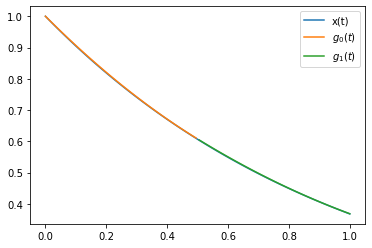

In [27]:
tt = np.linspace(0, 1, 100)

plt.plot(tt, sympy.lambdify(t, x)(tt), label='x(t)')
plt.plot(tt[:50], sympy.lambdify(t, g0)(tt[:50]), label=r"$g_0(t)$")
plt.plot(tt[50:], sympy.lambdify(t, g1)(tt[50:]), label=r"$g_1(t)$")
plt.legend()

### 二维热传导

#### 基函数展开

二元函数的泰勒展开式为:

$$
\begin{eqnarray*} f(x_0 + h, y_0 + k) & = &f(x_0 , y_0) + f_x(x_0 , y_0)h + f_y(x_0 , y_0)k+\\& &+\frac{1}{2!}\Big[f_{xx}(x_0 , y_0)h^2 + 2f_{xy}(x_0 , y_0)hk + f_{yy}k^2\Big]+\cdots \end{eqnarray*} 
$$

如果将FEM函数$f(x, y)$展开为二阶，即将其映射到$(1, x, x^2, y, y^2, xy)$基函数表示的近似解$g(x, y)$上，每个元素会产生6个待定系数。

$$f(x, y) \approx c_0 + c_1x + c_2x^2 + c_3y + c_4y^2 + c_5 xy$$

重新考虑二维有源热传导问题$u_{xx} + u_{yy} + 1 = 0$

In [28]:
x, y = sympy.symbols("x, y")
c0, c1, c2, c2, c3, c4= sympy.symbols("c0, c1, c2, c2, c3, c4")
f = c0 + c1*x + c2*x**2 + c3*y + c4*y**2
R = f.diff(x, 2) + f.diff(y, 2) + 1
display(R)

2*c2 + 2*c4 + 1

残差函数$R$与坐标x和y无关，可以满足$R(x, y)=0$。无需使用伽辽金法等弱约束条件。

对于边界条件的约束，可以直接使用特定坐标函数值：

In [29]:
Eq1 = f.subs(x, 0).subs(y, 0.5)
Eq2 = f.subs(x, 1).subs(y, 0.5)
Eq3 = f.subs(x, 0.5).subs(y, 0)
Eq4 = f.subs(x, 0.5).subs(y, 1)
display(Eq1)
display(Eq2)
display(Eq3)
display(Eq4)

c0 + 0.5*c3 + 0.25*c4

c0 + c1 + c2 + 0.5*c3 + 0.25*c4

c0 + 0.5*c1 + 0.25*c2

c0 + 0.5*c1 + 0.25*c2 + c3 + c4

In [30]:
sol = sympy.solve((R, Eq1, Eq2, Eq3, Eq4), (c0, c1, c2, c2, c3, c4))
f1 = f.subs(sol)
f1

-0.25*x**2 + 0.25*x - 0.25*y**2 + 0.25*y - 0.0625

也可以在边界上进行加权积分（权函数为试函数本身）：

In [31]:
Eq1 = sympy.integrate(y*f.subs(x, 0), (y, 0, 1))
Eq2 = sympy.integrate(y*f.subs(x, 1), (y, 0, 1))
Eq3 = sympy.integrate(x*f.subs(y, 0), (x, 0, 1))
Eq4 = sympy.integrate(x*f.subs(y, 1), (x, 0, 1))

In [32]:
sol = sympy.solve((R, Eq1, Eq2, Eq3, Eq4), (c0, c1, c2, c2, c3, c4))
f2 = f.subs(sol)
f2

-x**2/4 + x/4 - y**2/4 + y/4 - 1/24

In [33]:
xx = yy = np.linspace(0, 1, 100)
X, Y = np.meshgrid(xx, yy)

data1 = sympy.lambdify([x, y], f1)(X, Y)
data2 = sympy.lambdify([x, y], f2)(X, Y)

np.max(data1), np.max(data2)

(6.248724619936741e-02, 0.08332057953270075)

由于没有细分区间，两种边界条件的计算误差都比较大。

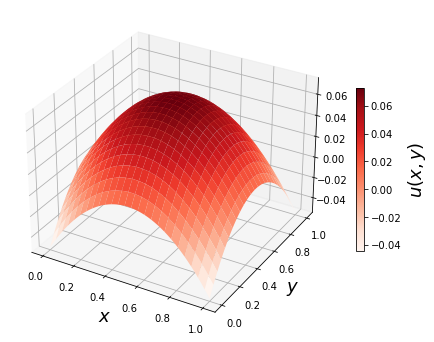

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={'projection': '3d'})

p = ax.plot_surface(X, Y, (data1+data2)/2, rstride=4, cstride=4, linewidth=0, cmap=mpl.cm.get_cmap("Reds"))
cb = fig.colorbar(p, shrink=0.5)

ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)

#### 空间网格划分

![](./Images/FEMShapes.gif)

如图所示，FEM网格形状常见为三角形、矩形、六边形等，FEM元素包含的节点数目各有区别。如果元素是一阶的，则只有在元素的顶点上出现格点，元素的每条边都为直线（线性拟合）。

这里我们将使用矩阵4节点（节点位置在矩形4边中点）网格，并搭配使用二阶拟合函数。

In [35]:
N = 50
grid_size = 1./N

x, y = sympy.symbols("x, y")
x0, y0 = sympy.symbols("x0, y0")

c0, c1, c2, c3, c4 = sympy.symbols("c0, c1, c2, c3, c4")
f = c0 + c1*(x-x0) + c2*(x-x0)**2 + c3*(y-y0) + c4*(y-y0)**2
R = f.diff(x, 2) + f.diff(y, 2) + 1
R

2*c2 + 2*c4 + 1

第一类边界条件：

In [36]:
value_left = f.subs(x, x0).subs(y, y0+grid_size/2)
value_right = f.subs(x, x0+grid_size).subs(y, y0+grid_size/2)
value_bottom = f.subs(x, x0+grid_size/2).subs(y, y0)
value_top = f.subs(x, x0+grid_size/2).subs(y, y0+grid_size)
display(value_left)
display(value_right)
display(value_bottom)
display(value_top)

c0 + 0.01*c3 + 0.0001*c4

c0 + 0.02*c1 + 0.0004*c2 + 0.01*c3 + 0.0001*c4

c0 + 0.01*c1 + 0.0001*c2

c0 + 0.01*c1 + 0.0001*c2 + 0.02*c3 + 0.0004*c4

第二类边界条件：

In [37]:
diff_left = f.diff(x).subs(x, x0).subs(y, y0+grid_size/2)
diff_right = f.diff(x).subs(x, x0+grid_size).subs(y, y0+grid_size/2)
diff_bottom = f.diff(y).subs(x, x0+grid_size/2).subs(y, y0)
diff_top = f.diff(y).subs(x, x0+grid_size/2).subs(y, y0+grid_size)
display(diff_left)
display(diff_right)
display(diff_bottom)
display(diff_top)

c1

c1 + 0.04*c2

c3

c3 + 0.04*c4

基元的数目为$N^2$个，待定系数有$5N^2$个，约束条件的总数至少需要$5N^2$个。

准备一个函数`extract_number`，用于提取约束条件中$c_n$的系数和$b$。

In [38]:
def extract_number(expr):
    b = n_c0 = n_c1 = n_c2 = n_c3 = n_c4 = 0
    if isinstance(expr, sympy.Number):
        b += expr
    if isinstance(expr, sympy.Symbol):
        if expr == c0:
            n_c0 += 1.
        if expr == c1:
            n_c1 += 1.
        if expr == c2:
            n_c2 += 1.
        if expr == c3:
            n_c3 += 1.
        if expr == c4:
            n_c4 += 1.
    if isinstance(expr, sympy.Mul):
        if expr.args[1] == c0:
            n_c0 += float(expr.args[0])
        if expr.args[1] == c1:
            n_c1 += float(expr.args[0])
        if expr.args[1] == c2:
            n_c2 += float(expr.args[0])
        if expr.args[1] == c3:
            n_c3 += float(expr.args[0])
        if expr.args[1] == c4:
            n_c4 += float(expr.args[0])
    if isinstance(expr, sympy.Add):
        return np.sum([extract_number(arg) for arg in expr.args], axis=0)
    return np.array([n_c0, n_c1, n_c2, n_c3, n_c4, b])

为了求解待定系数，将约束条件依次写入矩阵$A$。这里我们将混合使用第一类和第二类边界条件。

In [39]:
A = np.zeros((5*N**2, 5*N**2))
b = np.zeros((5*N**2))

for i in range(N):
    for j in range(N):
        idx = i*N + j
        # R 
        A[idx*5, idx*5:idx*5+5] = extract_number(R)[:5]
        b[idx*5] = -extract_number(R)[-1]
        # value_left(i, j) = value_right(i, j-1)
        if j == 0:
            A[idx*5+1, idx*5:idx*5+5] = extract_number(value_left)[:5]
        else:
            A[idx*5+1, idx*5:idx*5+5] = extract_number(value_left)[:5]
            A[idx*5+1, idx*5-5:idx*5] = -extract_number(value_right)[:5]
        # value_right(i, j) = value_left(i, j+1)
        if j == N-1:
            A[idx*5+2, idx*5:idx*5+5] = extract_number(value_right)[:5]
        else:
            A[idx*5+2, idx*5:idx*5+5] = extract_number(diff_right)[:5]
            A[idx*5+2, idx*5+5:idx*5+10] = -extract_number(diff_left)[:5]
        # value_bottom(i, j) = value_top(i-1, j)
        if i == 0:
            A[idx*5+3, idx*5:idx*5+5] = extract_number(value_bottom)[:5]
        else:
            A[idx*5+3, idx*5:idx*5+5] = extract_number(value_bottom)[:5]
            A[idx*5+3, idx*5-5*N:idx*5-5*N+5] = -extract_number(value_top)[:5]
        # value_top(i, j) = value_bottom(i+1, j)
        if i == N-1:
            A[idx*5+4, idx*5:idx*5+5] = extract_number(value_top)[:5]
        else:
            A[idx*5+4, idx*5:idx*5+5] = extract_number(diff_top)[:5]
            A[idx*5+4, idx*5+5*N:idx*5+5*N+5] = -extract_number(diff_bottom)[:5]

将矩阵A转换为稀疏矩阵求解。

In [40]:
#%time sol = la.solve(A, b)

B = sp.csr_matrix(A)
%time sol = sp.linalg.spsolve(B, b)

CPU times: user 62.9 ms, sys: 10.8 ms, total: 73.7 ms
Wall time: 75.5 ms


In [41]:
def g(i, j, x, y):
    x0 = i*grid_size
    y0 = j*grid_size
    c0, c1, c2, c3, c4 = sol[(i+j*N)*5:(i+j*N)*5+5].tolist()
    return c0 + c1*(x-x0) + c2*(x-x0)**2 + c3*(y-y0) + c4*(y-y0)**2

In [42]:
%matplotlib widget
xx = yy = np.linspace(0, 1, 100)
X, Y = np.meshgrid(xx, yy)
data = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        data[i, j] = g(int(i/(100/N)), int(j/(100/N)), i/100, j/100)

np.max(data)

0.07368295765492519

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
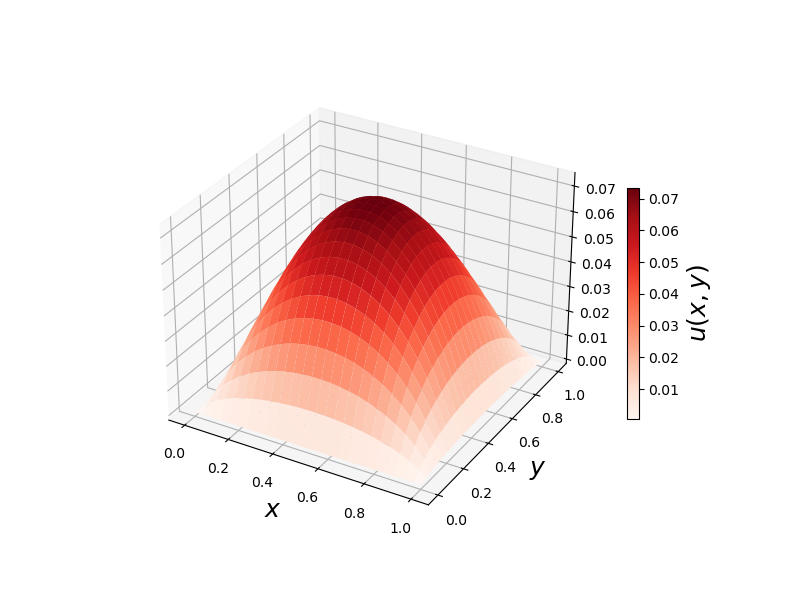

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={'projection': '3d'})

p = ax.plot_surface(X, Y, data, rstride=4, cstride=4, linewidth=0, cmap=mpl.cm.get_cmap("Reds"))
cb = fig.colorbar(p, shrink=0.5)

ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)

可以发现，相对于有限差分方法，在搭配使用高阶拟合函数后，有限元方法使用50%的节点密度获得了更好的数值精度。